In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.06G/1.06G [00:07<00:00, 220MB/s]
100% 1.06G/1.06G [00:07<00:00, 151MB/s]


In [ ]:
import zipfile

In [ ]:
ziprefrence=zipfile.ZipFile('/content/dogs-vs-cats.zip')

In [ ]:
ziprefrence.extractall('/content')

In [ ]:
ziprefrence.close()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
# we use generator to divide data into different batches, basically we use it when we have very huge data
# in RAM it processes the first bacth then move to different batch thats how generator works

In [ ]:
con_base=VGG16(
    weights='imagenet',
    include_top=False,    # include top is for dense layers
    input_shape=(150,150,3)

)

58889256/58889256 [==============================] - 0s 0us/step


#it's set to 'inferred'. When labels are inferred, it means that Keras will attempt to automatically determine the class labels for each image based on the subdirectories within the specified directory. Each subdirectory is assumed to correspond to a different class, and Keras will use the subdirectory names as class labels

In [ ]:
con_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model=Sequential()
model.add(con_base)  # it basically add vgg16's convolutional layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
con_base.trainable=False   # we freeze the vgg16's convolutional layer weights and biases

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import keras
train_data=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 20000 files belonging to 2 classes.


In [ ]:
test_data=keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 5000 files belonging to 2 classes.


In [ ]:
# let's normalize the data,
# given data is available in numpy array format which range from 0 to 255,
# and we wanted to convert that into 0 to 1

In [ ]:
import tensorflow
def process(image, label):
  image=tensorflow.cast(image/255., tensorflow.float32)
  return image, label

train_data=train_data.map(process)
test_data=test_data.map(process)

In [ ]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
625/625 [==============================] - 78s 103ms/step - loss: 1.5364 - accuracy: 0.5859 - val_loss: 0.6278 - val_accuracy: 0.6546
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 0.5783 - accuracy: 0.6982 - val_loss: 0.5764 - val_accuracy: 0.6934
Epoch 3/10
625/625 [==============================] - 65s 103ms/step - loss: 0.4966 - accuracy: 0.7502 - val_loss: 0.5589 - val_accuracy: 0.7346
Epoch 4/10
625/625 [==============================] - 65s 103ms/step - loss: 0.4577 - accuracy: 0.7761 - val_loss: 0.5139 - val_accuracy: 0.7332
Epoch 5/10
625/625 [==============================] - 65s 103ms/step - loss: 0.3963 - accuracy: 0.8027 - val_loss: 0.4335 - val_accuracy: 0.7926
Epoch 6/10
625/625 [==============================] - 67s 107ms/step - loss: 0.3462 - accuracy: 0.8299 - val_loss: 0.5097 - val_accuracy: 0.7372
Epoch 7/10
625/625 [==============================] - 65s 103ms/step - loss: 0.2978 - accuracy: 0.8585 - val_loss: 0.4911 - val_ac

In [ ]:
import pandas as pd
loss=pd.DataFrame(model.history.history)

In [ ]:
loss

,loss,accuracy,val_loss,val_accuracy
0,1.536435,0.58590,0.627820,0.6546
1,0.578283,0.69820,0.576436,0.6934
2,0.496620,0.75015,0.558936,0.7346
3,0.457750,0.77615,0.513914,0.7332
4,0.396257,0.80270,0.433513,0.7926
5,0.346225,0.82995,0.509657,0.7372
6,0.297789,0.85850,0.491102,0.7820
7,0.254874,0.88120,0.474335,0.7668
8,0.221544,0.89885,0.460130,0.8182
9,0.185563,0.91750,0.591544,0.8242


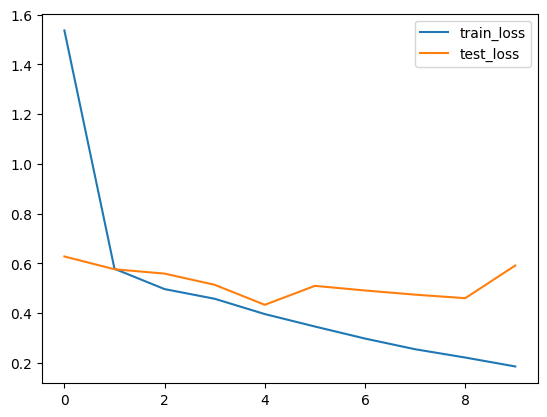

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss['loss'], label='train_loss')
plt.plot(loss['val_loss'], label='test_loss')
plt.legend()

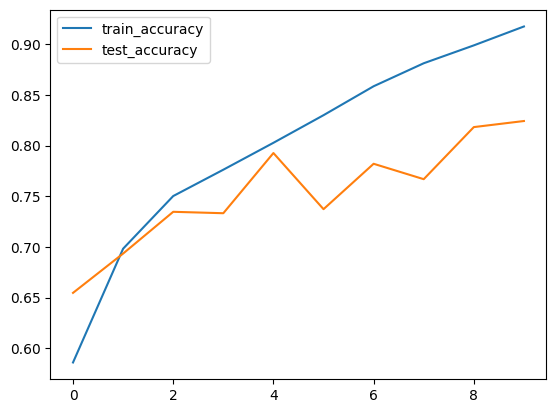

In [ ]:
plt.plot(loss['accuracy'], label='train_accuracy')
plt.plot(loss['val_accuracy'], label='test_accuracy')
plt.legend()

In [ ]:
# both test and train clearly indicates the overfitting

In [ ]:
# way to reduce overfitting
# 1) add more data
# 2) data augmentation
# 3) L1/L2 Regularizer
# 4) Droupout
# 5) Batch Normalization
# 6) Reduce Model Complexity
# 7) Early Stopping

In [ ]:
import cv2

In [ ]:
new_cat_image=cv2.imread('/content/Himalayan-chocolate-point.webp')

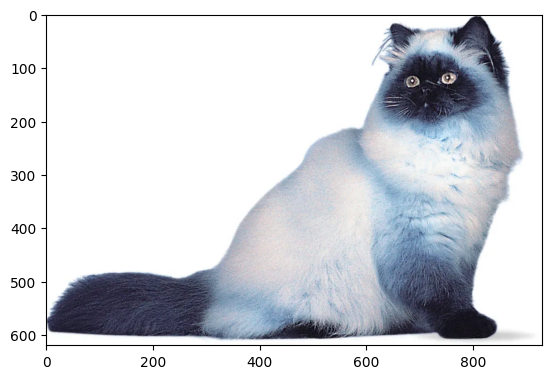

In [ ]:
plt.imshow(new_cat_image)

In [ ]:
new_dog_image=cv2.imread('/content/maltese-portrait.jpg')

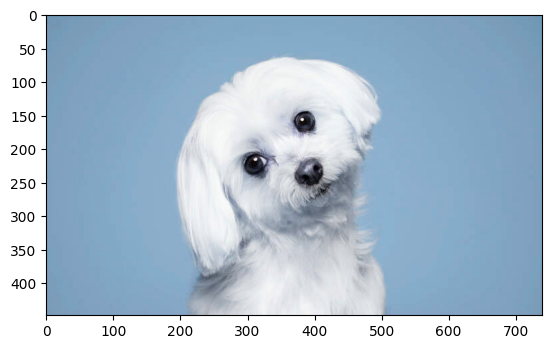

In [ ]:
plt.imshow(new_dog_image)

In [ ]:
new_cat_image.shape

(620, 930, 3)

In [ ]:
new_dog_image.shape

(448, 740, 3)

In [ ]:
new_cat_image=cv2.resize(new_cat_image,(256, 256))

In [ ]:
cat_input=new_cat_image.reshape((1,256, 256, 3))   # one is for batch

In [ ]:
model.predict(cat_input)

1/1 [==============================] - 0s 18ms/step


array([[0.3622914]], dtype=float32)

In [ ]:
new_dog_image.shape

(448, 740, 3)

In [ ]:
new_dog_image=cv2.resize(new_dog_image,(256, 256))

In [ ]:
dog_input=new_dog_image.reshape((1, 256, 256, 3))

In [ ]:
model.predict(dog_input)

1/1 [==============================] - 0s 18ms/step


array([[1.]], dtype=float32)

In [ ]:
# 0 means cat, and
# 1 means dog.

In [ ]:
# Fine Tuning
con_base.trainable=True

In [ ]:
set_trainable=False

In [ ]:
con_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
con_base.trainable=True
set_trainable = False  # Initialize set_trainable to False

for layer in con_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in con_base.layers:
    print(layer.name, layer.trainable)


input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
